# BirdNET feature extraction
BirdNET is a commonly used bird species detection algorithm. It is trained on ~6000 species, making it highly specialised at recognising patterns in spectrograms that relate to bird species.

Generally BirdNET requires audio as input, however in this instance I modify the PNG spectrogram images into a format the model accepts.
- Flatten spectrograms
- Zero padded to 144000 features

In [21]:
import os
import numpy as np
import umap
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import plotly.express as px
from birdnet_functions import extract_features

In [ ]:
## Test with one png image
image_path = "/Users/morganlangley/Desktop/chirrup_dat/images_dataset/Tadorna_tadorna/7125.png"
feature_vector = extract_features(image_path)
print(f"Extracted Feature Vector: {feature_vector}")
feature_vector.shape

Extracted Feature Vector: [[-10.334015 -12.69505   -8.852386 ... -12.228524  -8.36566  -11.307931]]


(1, 6522)

In [ ]:
## Directory containing the spectrogram images
spectrogram_dir = "/Users/morganlangley/Desktop/chirrup_dat/images_dataset/Charadrius_hiaticula"

# Initialise lists to store the features and filenames
features = []
file_names = []

# Loop through all spectrograms in the directory
for file in os.listdir(spectrogram_dir):
    if file.endswith(".png"):
        file_path = os.path.join(spectrogram_dir, file)
        
        # Extract features for image
        feature_vector = extract_features(file_path)
        
        # Append the feature vector and the filename to lists
        features.append(feature_vector)
        file_names.append(file)

# Convert the list of feature vectors into a NumPy array
features = np.array(features)

In [ ]:
## Reshape and standardise features

# Reshape
features_flattened = features.reshape(features.shape[0], -1)
features_flattened.shape

## Standardise
features_norm = StandardScaler().fit_transform(features_flattened)

(2557, 6522)

In [ ]:
### Perform UMAP
umap_embedding = umap.UMAP(
    metric='euclidean',
  #  n_neighbors=5,
    min_dist=0.2,
    n_components=2,
    random_state=42
).fit_transform(features_norm)

# Create a DataFrame with UMAP results and corresponding filenames
umap_df = pd.DataFrame(umap_embedding, columns=['UMAP1', 'UMAP2'])
umap_df['filename'] = file_names

/Users/morganlangley/jupyter_chirrup/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/morganlangley/jupyter_chirrup/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/5f/_qpdml8102754ng56snwrhnw0000gn/T/ipykernel_74378/2570308406.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  umap_df['distance_from_centroid'] = ((umap_df['UMAP1'] - centroid[0]) ** 2 + (umap_df['UMAP2'] - centroid[1]) ** 2) ** 0.5


/var/folders/5f/_qpdml8102754ng56snwrhnw0000gn/T/ipykernel_74378/4119766286.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  umap_df['distance_from_centroid'] = ((umap_df['UMAP1'] - centroid[0]) ** 2 + (umap_df['UMAP2'] - centroid[1]) ** 2) ** 0.5
/var/folders/5f/_qpdml8102754ng56snwrhnw0000gn/T/ipykernel_74378/4119766286.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(centroid[0], centroid[1], color='red', s=100, label='Centroid', alpha = 0.8)


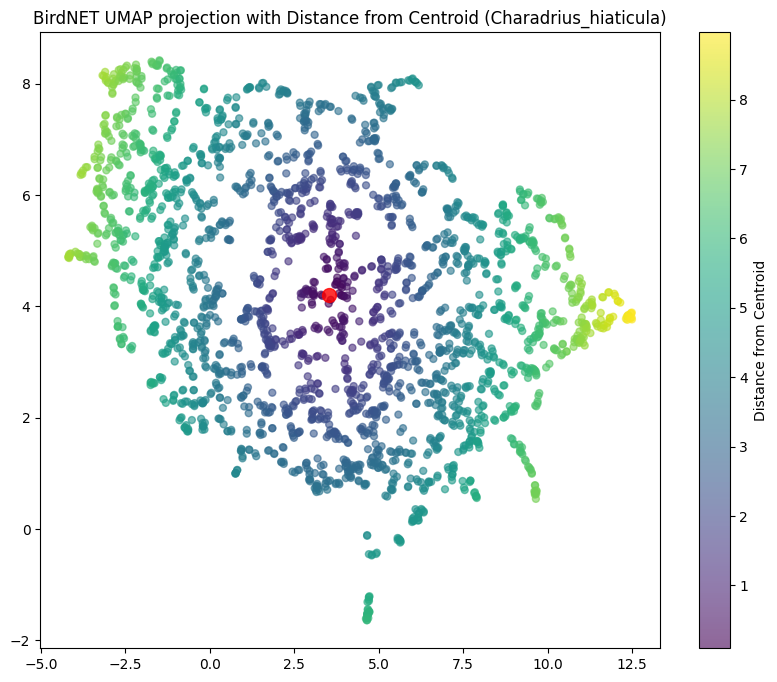

Outliers:           UMAP1     UMAP2    filename  distance_from_centroid
5     10.992419  3.417991   37239.png                7.499233
23    -3.765597  4.901015  343992.png                7.333261
32    -3.178380  8.149796   37013.png                7.787885
49    10.705832  4.378155   37615.png                7.173838
75    -3.632996  6.501279   37365.png                7.527252
...         ...       ...         ...                     ...
2507   9.622404  0.618328  344174.png                7.064155
2515  -2.376978  8.085320   37963.png                7.073149
2524  11.653195  3.604166  344014.png                8.140925
2529   9.670582  0.677295  343747.png                7.076171
2535  11.572465  3.759487   23043.png                8.050403

[215 rows x 4 columns]


In [ ]:
## Centroid methodology

# Calculate the centroid (mean) of the points
centroid = umap_df[['UMAP1', 'UMAP2']].mean()

# Calculate the Euclidean distance of each point from the centroid
umap_df['distance_from_centroid'] = ((umap_df['UMAP1'] - centroid[0]) ** 2 + (umap_df['UMAP2'] - centroid[1]) ** 2) ** 0.5

# Visualize the UMAP embedding
plt.figure(figsize=(10, 8))
plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'],
            c=umap_df['distance_from_centroid'], cmap='viridis',
            alpha=0.6, s=25)
plt.colorbar(label='Distance from Centroid')
plt.title('BirdNET UMAP projection with Distance from Centroid (Charadrius_hiaticula)')

# Add centroid location
plt.scatter(centroid[0], centroid[1], color='red', s=100, label='Centroid', alpha = 0.8)

# Define outlier threshold
outliers_threshold = 7  # distance from centroid
outliers = umap_df[umap_df['distance_from_centroid'] > outliers_threshold]

# Annotate outliers on the plot
#for i, row in outliers.iterrows():
#   plt.annotate(row['filename'], (row['UMAP1'], row['UMAP2']), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=9)

# Plot and print outliers
plt.show()
print("Outliers:", outliers)

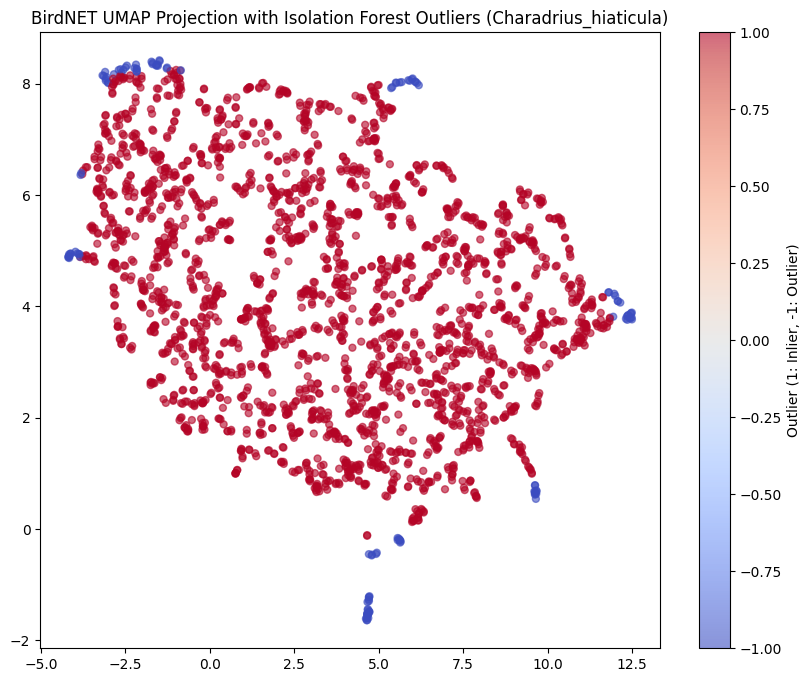

In [ ]:
## Isolation Forest methodology

# Set model params
iso_forest = IsolationForest(contamination=0.05, # Expected outlier percentage
                             random_state=42,    # Random state
                             n_estimators = 200) # Estimators (more = higher compute)

# Predict on data
outliers = iso_forest.fit_predict(umap_embedding)

# Convert to a DF with UMAP results and outlier labels
umap_df = pd.DataFrame(umap_embedding, columns=['UMAP1', 'UMAP2'])
umap_df['Outlier'] = outliers  # -1 = outlier, 1 = inlier
umap_df['filename'] = file_names

# Visualise
plt.figure(figsize=(10, 8))
plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], c=umap_df['Outlier'], cmap='coolwarm', alpha=0.6, s=25)
plt.colorbar(label='Outlier (1: Inlier, -1: Outlier)')
plt.title('BirdNET UMAP Projection with Isolation Forest Outliers (Charadrius_hiaticula)')
plt.show()

In [ ]:
## Outlier data

# Outliers
outlier_filenames = umap_df[umap_df['Outlier'] == -1]['filename'].tolist()
print("Outliers:", outlier_filenames)

# Inliers
inlier_filenames = umap_df[umap_df['Outlier'] == 1]['filename'].tolist()
print("Inliers:", inlier_filenames)

In [22]:
## 3D plot with isolation forest

# Standardise
features_norm = StandardScaler().fit_transform(features_flattened)

# 3D UMAP
umap_3d = umap.UMAP(
    metric='euclidean',
    min_dist=0.2,
    n_components=3,
    random_state=42
).fit_transform(features_norm)

# Isolation Forest
iso_forest = IsolationForest(
    contamination=0.05,
    random_state=42,
    n_estimators=200
)
outliers = iso_forest.fit_predict(umap_3d)

# DF
umap_df = pd.DataFrame(umap_3d, columns=['UMAP1', 'UMAP2', 'UMAP3'])
umap_df['Outlier'] = outliers  # -1 = outlier, 1 = inlier
umap_df['filename'] = file_names

# Map outlier df to string
umap_df['Outlier_Label'] = umap_df['Outlier'].map({1: 'Inlier', -1: 'Outlier'})

# Plot
fig = px.scatter_3d(
    umap_df,
    x='UMAP1',
    y='UMAP2',
    z='UMAP3',
    color='Outlier_Label',
    hover_name='filename',
    title='BirdNET 3D UMAP Projection with Isolation Forest Outliers (Corvus_cornix)',
    color_discrete_map={'Inlier': 'blue', 'Outlier': 'red'}
)

fig.update_traces(marker=dict(size=4, opacity=0.7))
fig.show()

/Users/morganlangley/jupyter_chirrup/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/morganlangley/jupyter_chirrup/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
